In [1]:
#Import all the necessary modules
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
from keras.callbacks import EarlyStopping,ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

from sklearn.preprocessing import PolynomialFeatures, StandardScaler  
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization , Flatten
from keras.models import Model
from keras.layers.convolutional import Conv2D , MaxPooling2D 
from keras.layers import BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc ,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers , layers
import tensorflow as tf
from tensorflow import keras
import time
import cv2
import os
import PIL
from glob import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
print (tf.__version__)

2.6.0


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/AIML/LABS/CNN/Plant Seedling Project/Part-1 - Plant Seedling Classification Data/train/*/*.png' 
files = glob(path) #return a list of pathnames

trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [ ]:
# Save data to file 
np.save("/content/drive/MyDrive/trainImg1.npy", trainImg)
trainLabel.to_csv("/content/drive/MyDrive/'trainLabel1.csv'", index=False)

In [3]:
# Load data to file
trainImg = np.load("/content/drive/MyDrive/trainImg1.npy")
trainLabel = pd.read_csv("/content/drive/MyDrive/'trainLabel1.csv'")
print(trainImg.shape)
print(trainLabel.head())

(4767, 128, 128, 3)
             0
0  Black-grass
1  Black-grass
2  Black-grass
3  Black-grass
4  Black-grass


In [4]:
trainLabel.columns = ['Label']

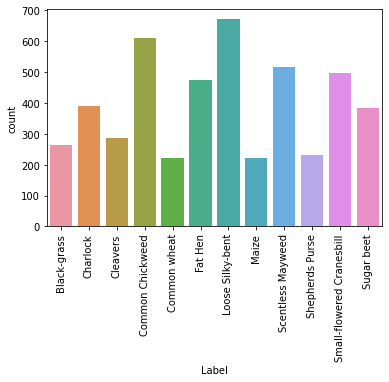

In [ ]:
sns.countplot(x='Label',data=trainLabel)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

seems Target class data is imbalanced.

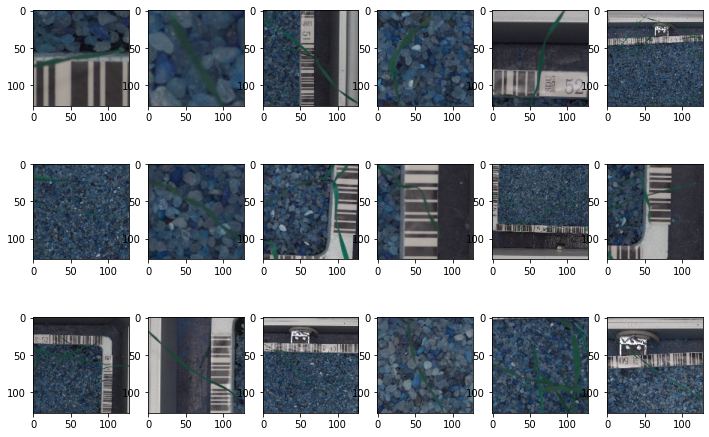

In [ ]:
# example images
plt.figure(figsize=(12,8)) 
for i in range(18):
    plt.subplot(3, 6, i + 1) 
    plt.imshow(trainImg[i])

#we Can observe all images are of diffrent shapes and have different backgorunds...applying filters will help in getting better accuarcy

For removing the background, We can create a mask, which will leave some range of green color and remove other part of image.

Masking green plant
For creating mask, which will remove background, we need to convert RGB image to HSV. HSV is alternative of the RGB color model. In HSV(HUE SATURATION and VALUE), it is easier to represent a color range than in RGB color space.

Steps to follow:
1.Use gaussian blur for remove noise
2.Convert color to HSV
3.Create mask
4.Create boolean mask
5.Apply boolean mask and getting image without background

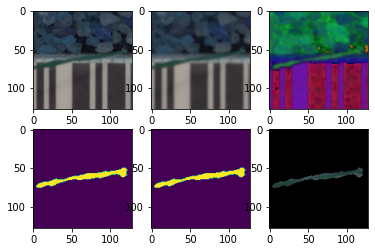

In [5]:
maskTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 50, 0)
    upper_green = (60, 255, 255)
    
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    maskTrainImg.append(clear)  # Append adds and object to the end of a list (image without backgroung)
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blurred image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

maskTrainImg = np.asarray(maskTrainImg)

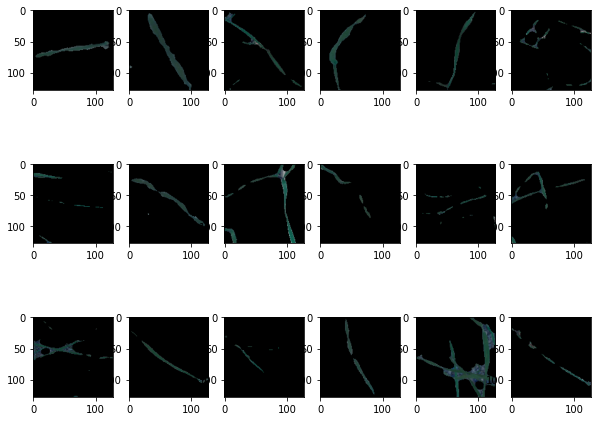

In [ ]:
# example images
plt.figure(figsize=(10,8)) 
for i in range(18):
    plt.subplot(3, 6, i + 1) 
    plt.imshow(maskTrainImg[i])

In [6]:
#Normalizing data
maskTrainImg = maskTrainImg.astype('float32') / 255

In [7]:
#one hot encoding for target varaible
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel['Label'])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel['Label'])

# Make labels categorical
maskTrainLabel = to_categorical(encodeTrainLabels)
num_clases = maskTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


In [ ]:
encodeTrainLabels.shape

(4767,)

In [ ]:
# As target classes are imblanced using startify on lables
X_train, X_test, y_train, y_test = train_test_split(maskTrainImg, encodeTrainLabels, 
                                                test_size=0.2, random_state=7, 
                                                stratify = encodeTrainLabels)

In [ ]:
#Checking shapes after one-hot encoding
print("X_train shape is", X_train.shape) 
print("y_train shape is", y_train.shape) 
print("X_test shape is", X_test.shape) 
print("y_test shape is", y_test.shape)

X_train shape is (3813, 128, 128, 3)
y_train shape is (3813,)
X_test shape is (954, 128, 128, 3)
y_test shape is (954,)


In [ ]:
trainX=X_train.copy()
trainy=y_train.copy()
testX=X_test.copy()
testy=y_test.copy()

In [ ]:
#As Classification models requires 2D data...shape X_train and X_test
X_train = X_train.reshape(X_train.shape[0],-1)
X_test  = X_test.reshape(X_test.shape[0],-1)

print("X_train shape is", X_train.shape) 
print("y_train shape is", y_train.shape) 
print("X_test shape is", X_test.shape) 
print("y_test shape is", y_test.shape)

X_train shape is (3813, 49152)
y_train shape is (3813,)
X_test shape is (954, 49152)
y_test shape is (954,)


KNN: 0.524784 (0.008433)
CART: 0.391555 (0.009899)
RF: 0.672965 (0.016277)
XGB: 0.692375 (0.010253)
SVC: 0.609499 (0.018901)


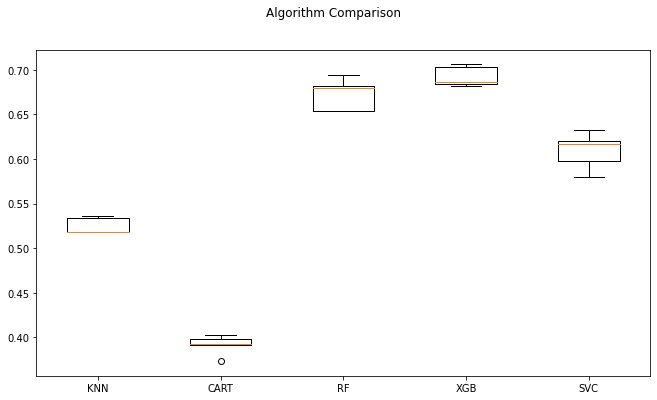

In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('SVC', SVC(kernel='linear',gamma='auto')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
        kfold = KFold(n_splits=5, random_state=seed,shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

XGB Classifier and Random Forest classfiers gave best accuracies.

Training RF Classifier using Cross validation

In [ ]:
rf = RandomForestClassifier(random_state=1)
cvs = cross_val_score(rf,X_train,y_train,cv=10)

## Show cross validation score mean and std
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))

## Fit the model with data
rf.fit(X_train, y_train)

## Accuracy
acc_rf = round(rf.score(X_test, y_test), 4)
print("Accuracy of Test set is : %0.4f" % (acc_rf))

## Predict y given validation set
predictions = rf.predict(X_test)

## Print classification report
print(classification_report(y_test, predictions))

Accuracy of Test set is : 0.7065
              precision    recall  f1-score   support

           0       0.19      0.06      0.09        53
           1       0.75      0.78      0.77        78
           2       0.64      0.84      0.73        58
           3       0.75      0.93      0.83       122
           4       0.73      0.18      0.29        44
           5       0.80      0.82      0.81        95
           6       0.62      0.87      0.73       135
           7       0.84      0.36      0.51        44
           8       0.59      0.72      0.65       103
           9       0.73      0.17      0.28        46
          10       0.79      0.91      0.85        99
          11       0.89      0.73      0.80        77

    accuracy                           0.71       954
   macro avg       0.69      0.61      0.61       954
weighted avg       0.70      0.71      0.67       954



In [ ]:
result = pd.DataFrame({'original' : y_test,'predicted' : predictions})
result.head()

,original,predicted
0,4,6
1,1,1
2,5,5
3,1,1
4,7,7


With RFClassifier we get 71% accuracy on test set.

0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3:'Common Chickweed',
      4: 'Common wheat', 5:'Fat Hen', 6:'Loose Silky-bent', 7: 'Maize',
       8:'Scentless Mayweed', 9:'Shepherds Purse',
       10: 'Small-flowered Cranesbill', 11: 'Sugar beet'

Model able to distinguish few major categories successfully.

Not able to identify categories 4,7 and 9 i.e. Common wheat, Maize and Shepherds Purse

failed to identify Black-grass

hyperparameters tuning for RandomForestClassifier

In [ ]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1000, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 500, 1000])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from sklearn.model_selection import cross_val_score
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)
best

with max_evals = 5

100%|██████████| 5/5 [00:31<00:00,  6.27s/it, best loss: -0.24416741485295992]
{'criterion': 1,
 'max_depth': 220.0,
 'max_features': 0,
 'min_samples_leaf': 0.22428690762531156,
 'min_samples_split': 0.5109729000142833,
 'n_estimators': 0}

10 evaluations:
 100%|██████████| 10/10 [01:50<00:00, 11.05s/it, best loss: -0.25150652040054633]
{'criterion': 1,
 'max_depth': 230.0,
 'max_features': 0,
 'min_samples_leaf': 0.16315851219392863,
 'min_samples_split': 0.13899320311340757,
 'n_estimators': 1}

In [ ]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 100, 3: 300, 4: 500,5:1000,6:1500}


print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

In [ ]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,y_train)
predictionforest = trainedforest.predict(X_test)

print("Accuracy score on Test set is ", accuracy_score(y_test,predictionforest))
print("\n classification Report " , classification_report(y_test,predictionforest))

result = pd.DataFrame({'original' : y_test,'predicted' : predictionforest})
result.head()

**NN Training**

In [8]:
# for NN trainig we can use one-hot encoded target varaible
X_train, X_test, y_train, y_test = train_test_split(maskTrainImg, maskTrainLabel, 
                                                test_size=0.2, random_state=7, 
                                                stratify = maskTrainLabel)

In [9]:
print("X_train shape is", X_train.shape) 
print("y_train shape is", y_train.shape) 
print("X_test shape is", X_test.shape) 
print("y_test shape is", y_test.shape)

X_train shape is (3813, 128, 128, 3)
y_train shape is (3813, 12)
X_test shape is (954, 128, 128, 3)
y_test shape is (954, 12)


In [ ]:
#reshape xtrain and xtest
X_train = X_train.reshape(X_train.shape[0],-1)
X_test  = X_test.reshape(X_test.shape[0],-1)

print("X_train shape is", X_train.shape) 
print("y_train shape is", y_train.shape) 
print("X_test shape is", X_test.shape) 
print("y_test shape is", y_test.shape)

X_train shape is (3813, 49152)
y_train shape is (3813, 12)
X_test shape is (954, 49152)
y_test shape is (954, 12)


In [ ]:
def basic_nn() :
    model = Sequential()
    model.add(Dense(512, input_shape = (49152, ),activation = 'relu'))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(12,activation = 'softmax'))

    return model

**Basic NN with SGD**

In [ ]:
basic_model = basic_nn()

sgd = optimizers.SGD(learning_rate = 0.01)
basic_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               25166336  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total params: 25,339,596
Trainable params: 25,339,596
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = basic_model.fit(X_train, y_train, validation_data = (X_test,y_test),batch_size = 300, epochs = 100, verbose = 1)

Epoch 1/50
13/13 [==============================] - 4s 92ms/step - loss: 2.4653 - accuracy: 0.1214 - val_loss: 2.4357 - val_accuracy: 0.1405
Epoch 2/50
13/13 [==============================] - 1s 54ms/step - loss: 2.4092 - accuracy: 0.1749 - val_loss: 2.3810 - val_accuracy: 0.2096
Epoch 3/50
13/13 [==============================] - 1s 54ms/step - loss: 2.3545 - accuracy: 0.2533 - val_loss: 2.3306 - val_accuracy: 0.2704
Epoch 4/50
13/13 [==============================] - 1s 52ms/step - loss: 2.3042 - accuracy: 0.2872 - val_loss: 2.2846 - val_accuracy: 0.2767
Epoch 5/50
13/13 [==============================] - 1s 54ms/step - loss: 2.2560 - accuracy: 0.2869 - val_loss: 2.2428 - val_accuracy: 0.2631
Epoch 6/50
13/13 [==============================] - 1s 53ms/step - loss: 2.2100 - accuracy: 0.2901 - val_loss: 2.1974 - val_accuracy: 0.2935
Epoch 7/50
13/13 [==============================] - 1s 54ms/step - loss: 2.1641 - accuracy: 0.3160 - val_loss: 2.1562 - val_accuracy: 0.3082
Epoch 8/50
13

In [ ]:
results = basic_model.evaluate(X_test, y_test)
print('accuracy Results: ', results)

30/30 [==============================] - 0s 6ms/step - loss: 1.9373 - accuracy: 0.4423
accuracy Results:  [1.9373409748077393, 0.44234800338745117]


with SGD we got accuracy of 56%

**Basic NN Model with ADAM optimizer**

In [ ]:
adam = optimizers.Adam(learning_rate = 0.01)
basic_model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               25166336  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                780       
Total params: 25,339,596
Trainable params: 25,339,596
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = basic_model.fit(X_train, y_train, validation_data = (X_test,y_test),batch_size = 300, epochs = 50, verbose = 1)

Epoch 1/50
13/13 [==============================] - 2s 80ms/step - loss: 90.6803 - accuracy: 0.1749 - val_loss: 2.3120 - val_accuracy: 0.2201
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 2.2294 - accuracy: 0.2633 - val_loss: 2.1515 - val_accuracy: 0.3124
Epoch 3/50
13/13 [==============================] - 1s 62ms/step - loss: 2.0190 - accuracy: 0.3318 - val_loss: 1.9317 - val_accuracy: 0.3438
Epoch 4/50
13/13 [==============================] - 1s 59ms/step - loss: 1.8018 - accuracy: 0.3819 - val_loss: 1.7399 - val_accuracy: 0.4078
Epoch 5/50
13/13 [==============================] - 1s 58ms/step - loss: 1.6361 - accuracy: 0.4154 - val_loss: 1.6489 - val_accuracy: 0.4392
Epoch 6/50
13/13 [==============================] - 1s 60ms/step - loss: 1.4766 - accuracy: 0.4742 - val_loss: 1.6429 - val_accuracy: 0.4151
Epoch 7/50
13/13 [==============================] - 1s 72ms/step - loss: 1.3848 - accuracy: 0.5056 - val_loss: 1.4891 - val_accuracy: 0.4738
Epoch 8/50
1

In [ ]:
results = basic_model.evaluate(X_test, y_test)
print('accuracy Results: ', results)

30/30 [==============================] - 0s 6ms/step - loss: 2.9483 - accuracy: 0.5314
accuracy Results:  [2.948277235031128, 0.5314465165138245]


With ADAM optimizer accuracy(57.8%) has been slightly improved

Model with BatchNormalization

In [ ]:
def basic_adam_nn() :
    model = Sequential()
    model.add(Dense(512, input_shape = (49152, ),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(128,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(64,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(12,activation = 'softmax'))

    adam = optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
adam_model = basic_adam_nn()
history = adam_model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size = 300, epochs = 50, verbose = 1)

Epoch 1/50
13/13 [==============================] - 3s 116ms/step - loss: 1.8078 - accuracy: 0.3845 - val_loss: 112.9753 - val_accuracy: 0.0839
Epoch 2/50
13/13 [==============================] - 1s 64ms/step - loss: 1.2675 - accuracy: 0.5539 - val_loss: 50.8045 - val_accuracy: 0.0985
Epoch 3/50
13/13 [==============================] - 1s 62ms/step - loss: 1.0779 - accuracy: 0.6134 - val_loss: 27.0465 - val_accuracy: 0.1562
Epoch 4/50
13/13 [==============================] - 1s 62ms/step - loss: 0.9116 - accuracy: 0.6743 - val_loss: 9.4469 - val_accuracy: 0.3229
Epoch 5/50
13/13 [==============================] - 1s 59ms/step - loss: 0.7431 - accuracy: 0.7351 - val_loss: 6.1027 - val_accuracy: 0.3344
Epoch 6/50
13/13 [==============================] - 1s 63ms/step - loss: 0.6142 - accuracy: 0.7818 - val_loss: 4.9921 - val_accuracy: 0.3648
Epoch 7/50
13/13 [==============================] - 1s 61ms/step - loss: 0.4926 - accuracy: 0.8303 - val_loss: 4.2581 - val_accuracy: 0.4340
Epoch 8/

In [ ]:
results = adam_model.evaluate(X_test, y_test)
print('accuracy Results: ', results)

30/30 [==============================] - 0s 8ms/step - loss: 2.2224 - accuracy: 0.6855
accuracy Results:  [2.2223596572875977, 0.6855345964431763]


In [10]:
def plot_model_accuracy() :
# Plot training & validation accuracy values
   plt.plot(history.history['accuracy'])
   plt.plot(history.history['val_accuracy'])
   plt.title('Model accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Val'], loc='upper left')
   plt.show()

def plot_model_loss() :
# Plot training & validation loss values
   plt.plot(history.history['loss'])
   plt.plot(history.history['val_loss'])
   plt.title('Model loss')
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Val'], loc='upper left')
   plt.show()

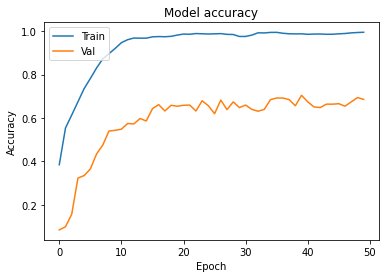

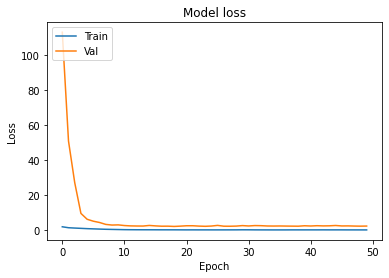

In [ ]:
plot_model_accuracy()
plot_model_loss()

Model performed very good with Training data and poor performance on validation set. Clear case of overfitting

Model with BatchNormalization and Dropout

In [ ]:
#model with Dropouts
def batchdrop__nn() :
    model = Sequential()
    model.add(Dense(512, input_shape = (49152, ),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(12,activation = 'softmax'))

    adam = optimizers.Adam(learning_rate = 0.01)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
batch_model = batchdrop__nn()
history = batch_model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size = 300, epochs = 50, verbose = 1)

Epoch 1/50
13/13 [==============================] - 3s 99ms/step - loss: 2.0959 - accuracy: 0.3092 - val_loss: 126.9049 - val_accuracy: 0.0839
Epoch 2/50
13/13 [==============================] - 1s 62ms/step - loss: 1.5654 - accuracy: 0.4639 - val_loss: 60.1792 - val_accuracy: 0.0922
Epoch 3/50
13/13 [==============================] - 1s 65ms/step - loss: 1.4026 - accuracy: 0.5111 - val_loss: 27.9555 - val_accuracy: 0.1205
Epoch 4/50
13/13 [==============================] - 1s 63ms/step - loss: 1.3155 - accuracy: 0.5437 - val_loss: 15.2384 - val_accuracy: 0.1530
Epoch 5/50
13/13 [==============================] - 1s 64ms/step - loss: 1.2422 - accuracy: 0.5628 - val_loss: 9.1358 - val_accuracy: 0.1740
Epoch 6/50
13/13 [==============================] - 1s 65ms/step - loss: 1.1690 - accuracy: 0.5822 - val_loss: 5.7893 - val_accuracy: 0.2830
Epoch 7/50
13/13 [==============================] - 1s 62ms/step - loss: 1.0479 - accuracy: 0.6292 - val_loss: 4.6546 - val_accuracy: 0.2966
Epoch 8/

In [ ]:
results = batch_model.evaluate(X_test, y_test)
print('accuracy Results: ', results)

30/30 [==============================] - 0s 7ms/step - loss: 1.6420 - accuracy: 0.6981
accuracy Results:  [1.6419968605041504, 0.698113203048706]


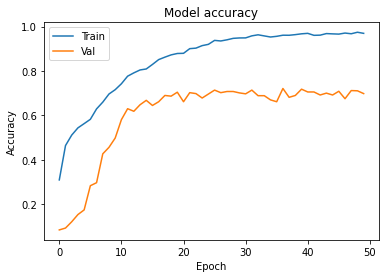

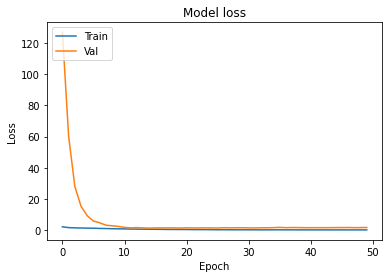

In [ ]:
plot_model_accuracy()
plot_model_loss()

Adding Dropout layer helped bit with accuarcy increase but not much helped in generalising to reduce overfitting ...

More training data is required and can be created with data augmentation

using **CNN**

In [ ]:
X_train = X_train.reshape(X_train.shape[0],128,128,3)
X_test  = X_test.reshape(X_test.shape[0],128,128,3)

print("X_train shape is", X_train.shape) 
print("y_train shape is", y_train.shape) 
print("X_test shape is", X_test.shape) 
print("y_test shape is", y_test.shape)

X_train shape is (3813, 128, 128, 3)
y_train shape is (3813, 12)
X_test shape is (954, 128, 128, 3)
y_test shape is (954, 12)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator with data augmentation 
datagen     = ImageDataGenerator(
                                rotation_range=180,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               brightness_range=None,
                               shear_range=0.0,
                               zoom_range=0.1,
                               channel_shift_range=0.0,
                               fill_mode='nearest',
                               horizontal_flip=True,
                               vertical_flip=True)

datagen.fit(X_train)

**CNN Model 1** 

In [ ]:
seed=7
np.random.seed(seed)  # Fix seed
IMG_SIZE = 128

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(12, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)      

Epoch 1/40
39/39 [==============================] - 15s 362ms/step - loss: 2.3102 - accuracy: 0.1970 - val_loss: 1.9633 - val_accuracy: 0.3155
Epoch 2/40
39/39 [==============================] - 14s 361ms/step - loss: 1.9266 - accuracy: 0.3050 - val_loss: 2.0107 - val_accuracy: 0.3260
Epoch 3/40
39/39 [==============================] - 14s 356ms/step - loss: 1.7821 - accuracy: 0.3630 - val_loss: 1.6815 - val_accuracy: 0.4298
Epoch 4/40
39/39 [==============================] - 14s 361ms/step - loss: 1.5806 - accuracy: 0.4338 - val_loss: 1.3393 - val_accuracy: 0.5294
Epoch 5/40
39/39 [==============================] - 14s 357ms/step - loss: 1.4718 - accuracy: 0.4721 - val_loss: 1.1649 - val_accuracy: 0.5933
Epoch 6/40
39/39 [==============================] - 14s 357ms/step - loss: 1.3763 - accuracy: 0.5104 - val_loss: 1.0979 - val_accuracy: 0.6331
Epoch 7/40
39/39 [==============================] - 14s 356ms/step - loss: 1.3347 - accuracy: 0.5319 - val_loss: 1.1316 - val_accuracy: 0.6059

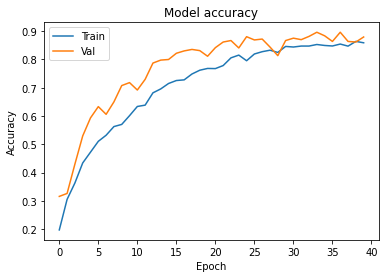

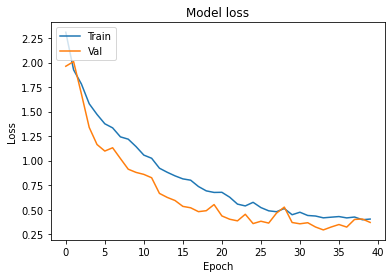

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100), 
                    epochs=40, validation_data=(X_test, y_test))
plot_model_accuracy()
plot_model_loss()

with CNN model1 got very good training accuracy and test accuracy of 87%.Loss also minimzed.

we can use earlystopping to aviod resource wastage

**CNN Model 2**

In [ ]:
IMG_SIZE = 128
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(12, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_42 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 62, 62, 64)        256       
_________________________________________________________________
dropout_18 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 128)      

Epoch 1/200
119/119 [==============================] - 28s 222ms/step - loss: 1.6431 - accuracy: 0.4914 - val_loss: 9.1402 - val_accuracy: 0.1415

Epoch 00001: val_loss improved from inf to 9.14018, saving model to best_model.h5
Epoch 2/200
119/119 [==============================] - 26s 220ms/step - loss: 1.1807 - accuracy: 0.6086 - val_loss: 6.4943 - val_accuracy: 0.1394

Epoch 00002: val_loss improved from 9.14018 to 6.49430, saving model to best_model.h5
Epoch 3/200
119/119 [==============================] - 26s 220ms/step - loss: 0.9099 - accuracy: 0.6895 - val_loss: 6.6341 - val_accuracy: 0.1101

Epoch 00003: val_loss did not improve from 6.49430
Epoch 4/200
119/119 [==============================] - 26s 221ms/step - loss: 0.8367 - accuracy: 0.7096 - val_loss: 9.3714 - val_accuracy: 0.0660

Epoch 00004: val_loss did not improve from 6.49430
Epoch 5/200
119/119 [==============================] - 26s 221ms/step - loss: 0.7170 - accuracy: 0.7556 - val_loss: 6.9099 - val_accuracy: 0.0

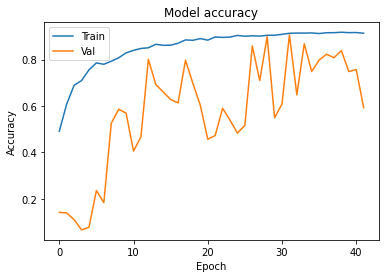

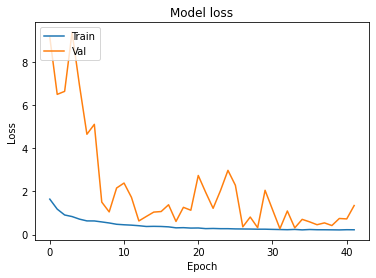

In [ ]:
batch_size=32
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.001)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience=10)
modelsave = ModelCheckpoint(
    filepath='best_model.h5', save_best_only=True, verbose=1)

history = model.fit_generator(datagen.flow(X_train, y_train), 
                    steps_per_epoch= len(X_train)//batch_size,   #Can be Length of training set
                    epochs=200,
                    validation_data=(X_test, y_test),
                    validation_steps= len(X_test)//batch_size,   #can be length of Test set
                    verbose=1,
                    callbacks=[annealer, modelsave,earlystop])

plot_model_accuracy()
plot_model_loss()

With Learning Rate reduction Technique val_loss did not improve from 0.51255

Learning rate schduler performed good comparing to LRreduction. val_loss reduced to 0.27253

in ReduceLROnPlateau, lr changes at the end of previous epoch, In LearningRateScheduler lr changes at the beginning of current epoch.



In [ ]:
#load best model from training
best_model= tf.keras.models.load_model('best_model.h5')

best_model.save('./best_model_cnn.h5')

best_model.save_weights('./best_model_cnn_weights.h5')

y_train_pred = best_model.predict(X_train, verbose=1).argmax(axis=1)
y_test_pred = best_model.predict(X_test, verbose=1).argmax(axis=1)

print("Accurancy:")
print("   Train: {:.2f}%".format(accuracy_score(y_train.argmax(axis=1), y_train_pred)*100))
print("   Test:  {:.2f}%".format(accuracy_score(y_test.argmax(axis=1), y_test_pred)*100))

print("\nF1-score")
print("   Train: {:.3f}%".format(f1_score(y_train.argmax(axis=1), y_train_pred, average='weighted')*100))
print("   Test:  {:.3f}%".format(f1_score(y_test.argmax(axis=1), y_test_pred, average='weighted')*100))

print("\nClassification Report")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

30/30 [==============================] - 2s 54ms/step
Accurancy:
   Train: 92.18%
   Test:  90.67%

F1-score
   Train: 91.097%
   Test:  89.230%

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.17      0.29        53
           1       0.97      0.96      0.97        78
           2       0.93      0.88      0.90        58
           3       0.92      0.98      0.94       122
           4       0.93      0.84      0.88        44
           5       0.94      0.99      0.96        95
           6       0.77      0.98      0.86       135
           7       0.96      0.98      0.97        44
           8       0.94      0.96      0.95       103
           9       0.94      0.70      0.80        46
          10       0.91      0.98      0.94        99
          11       0.97      1.00      0.99        77

    accuracy                           0.91       954
   macro avg       0.92      0.87      0.87       954
weighted avg       0

In [ ]:
trainLabel['Label'].unique()

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

From above results we can observe CNN Model2 performed good on both sets. Both accuracies are good and model didnt overfit.

For test set we got accuracy of 90.4%.

From classification report we can understand model well idntified category 1,3,5,8,10 and 11 followed by 2,6,7 and 9.

Model doesnt identify correctly about 0 and 4 i.e. Black-grass and Scentless Mayweed


Model Trianing using **VGG16** 

In [ ]:
from keras.applications.vgg16 import VGG16

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(128, 128, 3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
   layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(12, activation='softmax')(x)

# create a model object
model1 = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model1.summary()

# tell the model what cost and optimization method to use
model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

Epoch 1/200
120/120 [==============================] - 22s 185ms/step - loss: 0.7379 - accuracy: 0.7404 - val_loss: 0.5876 - val_accuracy: 0.7977

Epoch 00001: val_accuracy improved from -inf to 0.79769, saving model to best_vgg.h5
Epoch 2/200
120/120 [==============================] - 22s 184ms/step - loss: 0.6919 - accuracy: 0.7590 - val_loss: 0.6053 - val_accuracy: 0.7904

Epoch 00002: val_accuracy did not improve from 0.79769
Epoch 3/200
120/120 [==============================] - 22s 180ms/step - loss: 0.6297 - accuracy: 0.7891 - val_loss: 0.5127 - val_accuracy: 0.8197

Epoch 00003: val_accuracy improved from 0.79769 to 0.81971, saving model to best_vgg.h5
Epoch 4/200
120/120 [==============================] - 22s 181ms/step - loss: 0.5947 - accuracy: 0.7994 - val_loss: 0.4912 - val_accuracy: 0.8166

Epoch 00004: val_accuracy did not improve from 0.81971
Epoch 5/200
120/120 [==============================] - 22s 180ms/step - loss: 0.5771 - accuracy: 0.8038 - val_loss: 0.5137 - val_

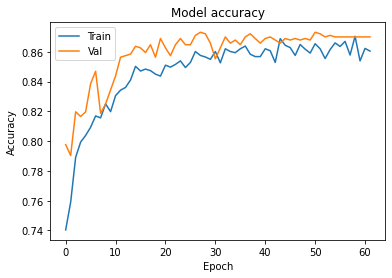

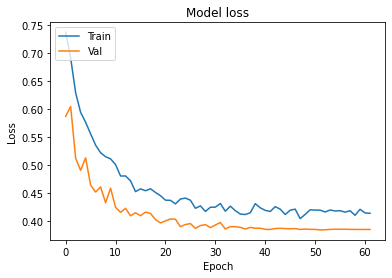

In [ ]:
batch_size=64
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience=10)
modelsave = ModelCheckpoint(
    monitor='val_accuracy',filepath='best_vgg.h5', save_best_only=True, verbose=1,mode='auto')

history = model1.fit_generator(datagen.flow(X_train, y_train), 
                    #steps_per_epoch= len(X_train)//batch_size,   #Can be Length of training set
                    epochs=200,
                    validation_data=(X_test, y_test),
                    #validation_steps= len(X_test)//batch_size,   #can be length of Test set
                    verbose=1,
                    callbacks=[annealer, earlystop,modelsave])

plot_model_accuracy()
plot_model_loss()

In [ ]:
#load best model from training
best_vgg= tf.keras.models.load_model('best_vgg.h5')

model1.save('./best_model_vgg.h5')
model1.save_weights('./best_model_vgg_weights.h5')

y_train_pred = model1.predict(X_train, verbose=1).argmax(axis=1)
y_test_pred = model1.predict(X_test, verbose=1).argmax(axis=1)

print("Accurancy:")
print("   Train: {:.2f}%".format(accuracy_score(y_train.argmax(axis=1), y_train_pred)*100))
print("   Test:  {:.2f}%".format(accuracy_score(y_test.argmax(axis=1), y_test_pred)*100))

print("\nF1-score")
print("   Train: {:.3f}%".format(f1_score(y_train.argmax(axis=1), y_train_pred, average='weighted')*100))
print("   Test:  {:.3f}%".format(f1_score(y_test.argmax(axis=1), y_test_pred, average='weighted')*100))

print("\nClassification Report")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

30/30 [==============================] - 2s 76ms/step
Accurancy:
   Train: 89.77%
   Test:  87.00%

F1-score
   Train: 89.191%
   Test:  86.000%

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.19      0.27        53
           1       0.94      1.00      0.97        78
           2       0.89      0.81      0.85        58
           3       0.94      0.98      0.96       122
           4       0.72      0.75      0.73        44
           5       0.92      0.89      0.91        95
           6       0.76      0.88      0.82       135
           7       0.84      0.93      0.88        44
           8       0.89      0.89      0.89       103
           9       0.87      0.89      0.88        46
          10       0.98      0.98      0.98        99
          11       0.86      0.88      0.87        77

    accuracy                           0.87       954
   macro avg       0.84      0.84      0.83       954
weighted avg       0

With VGG16 we get an accuracy of 85.6% on testset.

Model able to distinguish all categories majorly except categoies 0 and 4 i.e. Black Grass and common wheat

CNN Model using **Inception**

In [ ]:
from keras.applications.inception_v3 import InceptionV3

# initialize the InceptionV3 model
# remove the final layer of the model and add 12 classess of plant seedlings
# input images: 128px by 128px.

incV3 = InceptionV3(weights='imagenet',include_top=False, input_shape=(128,128,3))

# don't train existing weights
for layer in incV3.layers:
   layer.trainable = False

# our layers - can add more custom layers
x = Flatten()(incV3.output)

prediction = Dense(12, activation='softmax')(x)

# create a model object
model2 = Model(inputs=incV3.input, outputs=prediction)

# view the structure of the model
model2.summary()

# tell the model what cost and optimization method to use
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
___________________________

Epoch 1/200
120/120 [==============================] - 23s 155ms/step - loss: 2.5076 - accuracy: 0.4810 - val_loss: 1.6094 - val_accuracy: 0.6394
Epoch 2/200
120/120 [==============================] - 16s 137ms/step - loss: 1.5859 - accuracy: 0.6168 - val_loss: 1.3720 - val_accuracy: 0.6593
Epoch 3/200
120/120 [==============================] - 16s 135ms/step - loss: 1.5593 - accuracy: 0.6331 - val_loss: 1.5075 - val_accuracy: 0.6426
Epoch 4/200
120/120 [==============================] - 16s 136ms/step - loss: 1.3517 - accuracy: 0.6596 - val_loss: 1.3758 - val_accuracy: 0.6268
Epoch 5/200
120/120 [==============================] - 17s 138ms/step - loss: 1.3952 - accuracy: 0.6614 - val_loss: 1.3047 - val_accuracy: 0.6939
Epoch 6/200
120/120 [==============================] - 16s 135ms/step - loss: 1.2332 - accuracy: 0.6753 - val_loss: 1.1690 - val_accuracy: 0.7306
Epoch 7/200
120/120 [==============================] - 16s 135ms/step - loss: 1.1043 - accuracy: 0.6989 - val_loss: 1.4738 -

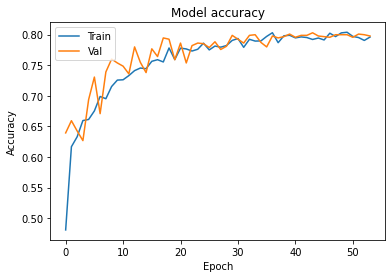

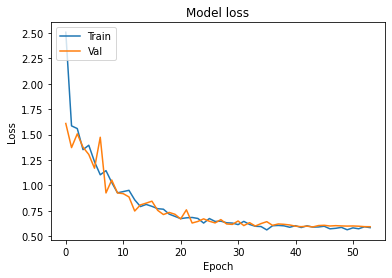

In [ ]:
batch_size=16
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience=10)

history = model2.fit_generator(datagen.flow(X_train, y_train), 
                    #steps_per_epoch= len(X_train)//batch_size,   #Can be Length of training set
                    epochs=200,
                    validation_data=(X_test, y_test),
                    #validation_steps= len(X_test)//batch_size,   #can be length of Test set
                    verbose=1,
                    callbacks=[annealer, earlystop])

plot_model_accuracy()
plot_model_loss()

In [ ]:
model1.save('./saved_model_inc.h5')
model1.save_weights('./saved_model_inc_weights.h5')

y_train_pred = model2.predict(X_train, verbose=1).argmax(axis=1)
y_test_pred = model2.predict(X_test, verbose=1).argmax(axis=1)

print("Accurancy:")
print("   Train: {:.2f}%".format(accuracy_score(y_train.argmax(axis=1), y_train_pred)*100))
print("   Test:  {:.2f}%".format(accuracy_score(y_test.argmax(axis=1), y_test_pred)*100))

print("\nF1-score")
print("   Train: {:.3f}%".format(f1_score(y_train.argmax(axis=1), y_train_pred, average='weighted')*100))
print("   Test:  {:.3f}%".format(f1_score(y_test.argmax(axis=1), y_test_pred, average='weighted')*100))

print("\nClassification Report")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

30/30 [==============================] - 1s 30ms/step
Accurancy:
   Train: 84.26%
   Test:  79.77%

F1-score
   Train: 84.090%
   Test:  79.111%

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.15      0.20        53
           1       0.86      0.99      0.92        78
           2       0.88      0.72      0.79        58
           3       0.91      0.79      0.85       122
           4       0.53      0.64      0.58        44
           5       0.90      0.85      0.88        95
           6       0.74      0.77      0.75       135
           7       0.84      0.86      0.85        44
           8       0.81      0.85      0.83       103
           9       0.65      0.78      0.71        46
          10       0.96      0.94      0.95        99
          11       0.74      0.91      0.82        77

    accuracy                           0.80       954
   macro avg       0.76      0.77      0.76       954
weighted avg       0

0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3:'Common Chickweed',
      4: 'Common wheat', 5:'Fat Hen', 6:'Loose Silky-bent', 7: 'Maize',
       8:'Scentless Mayweed', 9:'Shepherds Purse',
       10: 'Small-flowered Cranesbill', 11: 'Sugar beet'

With Inception V3 - we got accurancy of 80% on Testset.

Model able to disguinish major categories except 0 4 and 9 i.e. Black-Grass , Common - Wheat and Shepherds Purse

In [ ]:
trainLabel

In [ ]:
# initialize the resnet50 model
# remove the final layer of the model and add 12 classess of plant seedlings
# input images: 128px by 128px.

xcptn = tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape=(128,128,3))

# don't train existing weights
for layer in xcptn.layers:
   layer.trainable = False

# our layers - can add more custom layers
x = Flatten()(xcptn.output)

prediction = Dense(12, activation='softmax')(x)

# create a model object
model3 = Model(inputs=xcptn.input, outputs=prediction)

# view the structure of the model
model3.summary()

# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  #optimizer='adam',
  optimizer= tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
,
  metrics=['accuracy']
)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
batch_size=64
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience=10)
modelsave = ModelCheckpoint(
    filepath='best_xcptn.h5', save_best_only=True, verbose=1,mode='auto')

history = model3.fit_generator(datagen.flow(X_train, y_train), 
                    epochs=100,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[annealer, earlystop,modelsave])

plot_model_accuracy()
plot_model_loss()

Epoch 1/100
120/120 [==============================] - 24s 198ms/step - loss: 1.3062 - accuracy: 0.7236 - val_loss: 1.5310 - val_accuracy: 0.7369

Epoch 00001: val_loss improved from inf to 1.53102, saving model to best_xcptn.h5
Epoch 2/100
120/120 [==============================] - 23s 195ms/step - loss: 1.4588 - accuracy: 0.7346 - val_loss: 1.7618 - val_accuracy: 0.7317

Epoch 00002: val_loss did not improve from 1.53102
Epoch 3/100
120/120 [==============================] - 23s 195ms/step - loss: 1.2187 - accuracy: 0.7608 - val_loss: 1.2447 - val_accuracy: 0.7767

Epoch 00003: val_loss improved from 1.53102 to 1.24469, saving model to best_xcptn.h5
Epoch 4/100
120/120 [==============================] - 23s 193ms/step - loss: 1.1337 - accuracy: 0.7671 - val_loss: 1.3017 - val_accuracy: 0.7820

Epoch 00004: val_loss did not improve from 1.24469
Epoch 5/100
120/120 [==============================] - 23s 194ms/step - loss: 0.9355 - accuracy: 0.7899 - val_loss: 1.0193 - val_accuracy: 0.7

In [ ]:
#load best model from training
best_xcptn= tf.keras.models.load_model('best_xcptn.h5')

model3.save('./saved_best_xcptn.h5')
model3.save_weights('./saved_best_xcptn_weights.h5')

y_train_pred = model3.predict(X_train, verbose=1).argmax(axis=1)
y_test_pred = model3.predict(X_test, verbose=1).argmax(axis=1)

print("Accurancy:")
print("   Train: {:.2f}%".format(accuracy_score(y_train.argmax(axis=1), y_train_pred)*100))
print("   Test:  {:.2f}%".format(accuracy_score(y_test.argmax(axis=1), y_test_pred)*100))

print("\nF1-score")
print("   Train: {:.3f}%".format(f1_score(y_train.argmax(axis=1), y_train_pred, average='weighted')*100))
print("   Test:  {:.3f}%".format(f1_score(y_test.argmax(axis=1), y_test_pred, average='weighted')*100))

print("\nClassification Report")
print(classification_report(y_test.argmax(axis=1), y_test_pred))

30/30 [==============================] - 3s 91ms/step
Accurancy:
   Train: 89.30%
   Test:  83.75%

F1-score
   Train: 88.951%
   Test:  83.211%

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.23      0.28        53
           1       0.92      0.94      0.93        78
           2       1.00      0.78      0.87        58
           3       0.89      0.85      0.87       122
           4       0.68      0.82      0.74        44
           5       0.88      0.94      0.91        95
           6       0.76      0.79      0.77       135
           7       0.85      0.91      0.88        44
           8       0.88      0.91      0.90       103
           9       0.70      0.76      0.73        46
          10       0.95      0.98      0.97        99
          11       0.84      0.88      0.86        77

    accuracy                           0.84       954
   macro avg       0.81      0.81      0.81       954
weighted avg       0

HyperParameter Tuning

In [26]:
def build_model(hp):  
  model = Sequential()
  model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(128,128,3)
    )),
  model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    )),
  #model.add(Conv2D(
  #      filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=32),
  #      kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
  #      activation='relu'
  #  )),
  model.add(Flatten()),
  model.add(Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=512, step=32),
        activation='relu'
    )),
  model.add(Dense(12, activation='softmax'))

  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import kerastuner as kt

#Random Search
#tuner_search=RandomSearch(build_model,
#                         objective='val_accuracy',
#                         max_trials=5,directory='output',project_name="Plant Seedlings")

#tuner_search.search(X_train,y_train,epochs=3,validation_data=(X_test,y_test))

#model=tuner_search.get_best_models(num_models=1)[0]
#model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test), initial_epoch=3)

# Instantiate the Tuner
hyperband_tuner = kt.Hyperband(
                  build_model,max_epochs=5,seed = 5,objective='val_accuracy',
                  directory='hyperband',project_name='Plant Seedlings')

hyperband_tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
hyperband_tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])

best_hp = tuner.get_best_hyperparamters()[0] 

# Build the model with the optimal hyperparameters
h_model = hyperband_tuner.hypermodel.build(best_hps)
h_model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test))

GPU not able to allocate memory to run hyperparameter tuning as input image size is huge and number of fileters and dense layers are huge 

Image **PREDCITION**

In [ ]:
def classify(img_path,model):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)

    img_ex = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_ex.astype('float32') / 255
  
    prediction = model.predict(img_preprocessed)

    predNum = np.argmax(prediction, axis=1)
    predStr = le.classes_[predNum]

    print("image predicted is ", predStr)

In [ ]:
os.chdir("/content/drive/MyDrive/AIML/LABS/CNN/Plant Seedling Project")
!pwd

/content/drive/MyDrive/AIML/LABS/CNN/Plant Seedling Project


In [ ]:
!ls

 best_model_cnn.h5	     best_model_vgg_weights.h5
 best_model_cnn_weights.h5   best_xcptn.h5
 best_model.h5		    'Part-1 - Plant Seedling Classification Data'
 best_model_vgg.h5	     saved_model_inc.h5


In [ ]:
img_path = "/content/drive/MyDrive/AIML/LABS/CNN/Plant Seedling Project/Part-1 - Plant Seedling Classification Data/Seedling - Prediction/Predict.png"
#img_path ="/content/drive/MyDrive/Predict.png"

#chekcing with Trianed CNN Model

model = keras.models.load_model('./best_model_cnn.h5')

classify(img_path,model)


image predicted is  ['Common Chickweed']


In [ ]:
#checking with VGG model
model = keras.models.load_model('./best_model_vgg.h5')
classify(img_path,model)

image predicted is  ['Scentless Mayweed']


In [ ]:
#checking with INC model
model = keras.models.load_model('./saved_model_inc.h5')
classify(img_path,model)

image predicted is  ['Scentless Mayweed']


In [ ]:
#checking with Xception model
model = keras.models.load_model('./best_xcptn.h5')
classify(img_path,model)

image predicted is  ['Maize']
